In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt

In [27]:
data_path = 'imputed 2007-2023 (1).csv'
df = pd.read_csv(data_path, parse_dates=['Date'])

In [28]:
# Normalisasi menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(np.array(df['close']).reshape(-1, 1))

In [29]:
# Pembagian data latih 90% dan data validasi 10%
training_size = int(len(df) * 0.9)
test_size = len(df) - training_size
train_data, test_data = df['close'][0:training_size], df['close'][training_size:len(df)]


In [30]:
def create_dataset(data, window_size=1):
    X, Y = [], []
    for i in range(len(data)-window_size-1):
        a = data[i:(i+window_size), 0]
        X.append(a)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [31]:

window_size = 30  # Jumlah lag untuk input
X_train, y_train = create_dataset(train_data.values.reshape(-1,1), window_size)
X_test, y_test = create_dataset(test_data.values.reshape(-1,1), window_size)

In [32]:

# Mengubah bentuk data untuk model regresi linier
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


In [33]:
# Model regresi linier
model = Sequential()
model.add(Dense(1, input_dim=window_size))

In [34]:
# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Pelatihan model
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/1000
112/112 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0015
Epoch 2/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/1000
112/112 [==============================] - 0s 2ms/step - loss: 0.001

In [36]:
# Prediksi menggunakan model yang telah dilatih
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [37]:
# Hasil prediksi di denormalisasi ke skala aslinya
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [38]:
# Mengeluarkan output metrik evaluasi
train_mape = mean_absolute_percentage_error(y_train, train_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

In [39]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train MAPE: {train_mape}, Train RMSE: {train_rmse}')
print(f'Test MAPE: {test_mape}, Test RMSE: {test_rmse}')

Train MAPE: 0.021438455269164245, Train RMSE: 24.99012759545084
Test MAPE: 0.024589895025579424, Test RMSE: 19.44605477203524


In [40]:
train_plot = np.empty_like(df['close'])
train_plot[:] = np.nan
train_plot[window_size:len(train_predict)+window_size] = train_predict[:,0]

In [41]:

test_plot = np.empty_like(df['close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(window_size*2)+1:len(df)-1] = test_predict[:,0]

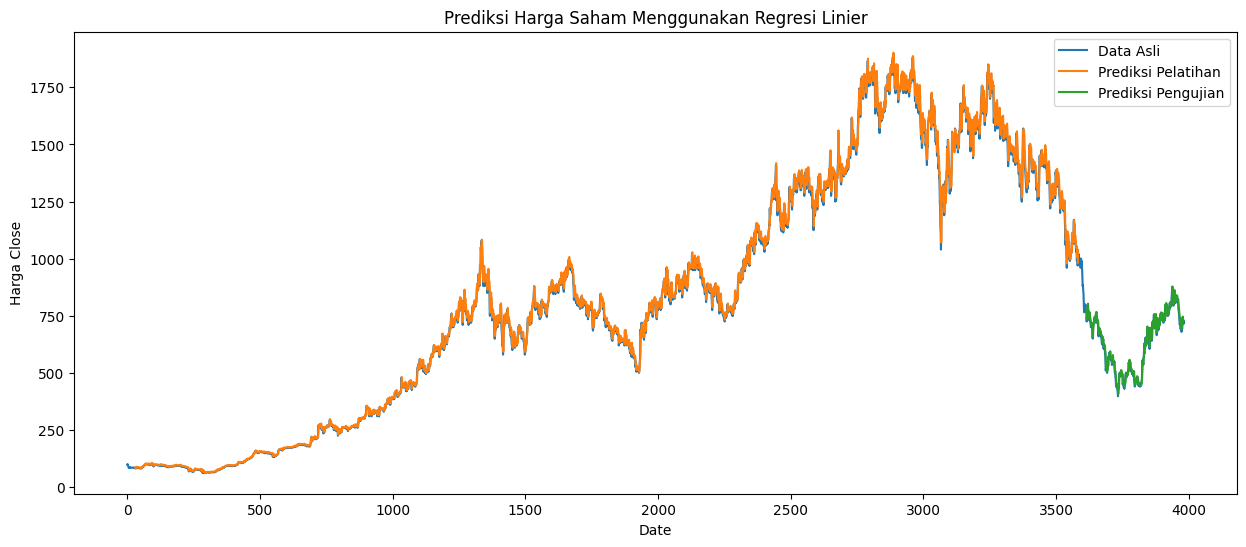

In [42]:
# Visualisasi hasil prediksi terhadap nilai asli
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Data Asli')
plt.plot(train_plot, label='Prediksi Pelatihan')
plt.plot(test_plot, label='Prediksi Pengujian')
plt.xlabel('Date')
plt.ylabel('Harga Close')
plt.title('Prediksi Harga Saham Menggunakan Regresi Linier')
plt.legend()
plt.show()

In [43]:
result_df = df[['Date']].copy()
result_df['Actual'] = scaler.inverse_transform(df['close'].values.reshape(-1, 1))
result_df['Train_Predict'] = np.nan
result_df['Test_Predict'] = np.nan

In [44]:
result_df.iloc[window_size:len(train_predict) + window_size, result_df.columns.get_loc('Train_Predict')] = train_predict[:, 0]
result_df.iloc[len(train_predict) + (window_size * 2) + 1:len(df) - 1,  result_df.columns.get_loc('Test_Predict')] = test_predict[:, 0]


In [45]:
# Fungsi untuk memprediksi harga masa depan
def predict_future_prices(model, data, window_size, future_days):
    future_predictions = []
    last_window = data[-window_size:]

    for day in range(future_days):
        pred = model.predict(last_window.reshape(1, window_size))
        future_predictions.append(pred[0, 0])
        last_window = np.append(last_window[1:], pred[0, 0])

    return np.array(future_predictions).reshape(-1, 1)

In [46]:
# Prediksi untuk 90 hari ke depan
future_days = 90
future_predictions = predict_future_prices(model, test_data.values, window_size, future_days)


1/1 [==============================] - 0s 20ms/step


In [47]:
# Nilai prediksi di denormalisasi agar berada pada rentang asli data
future_predictions = scaler.inverse_transform(future_predictions)

In [48]:
future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=future_days)
future_df = pd.DataFrame({'Date': future_dates, 'Future_Predict': future_predictions.flatten()})


In [49]:
# Data asli dan prediksi masa depan ke dalam DataFrame
result_df = pd.concat([result_df, future_df], ignore_index=True)

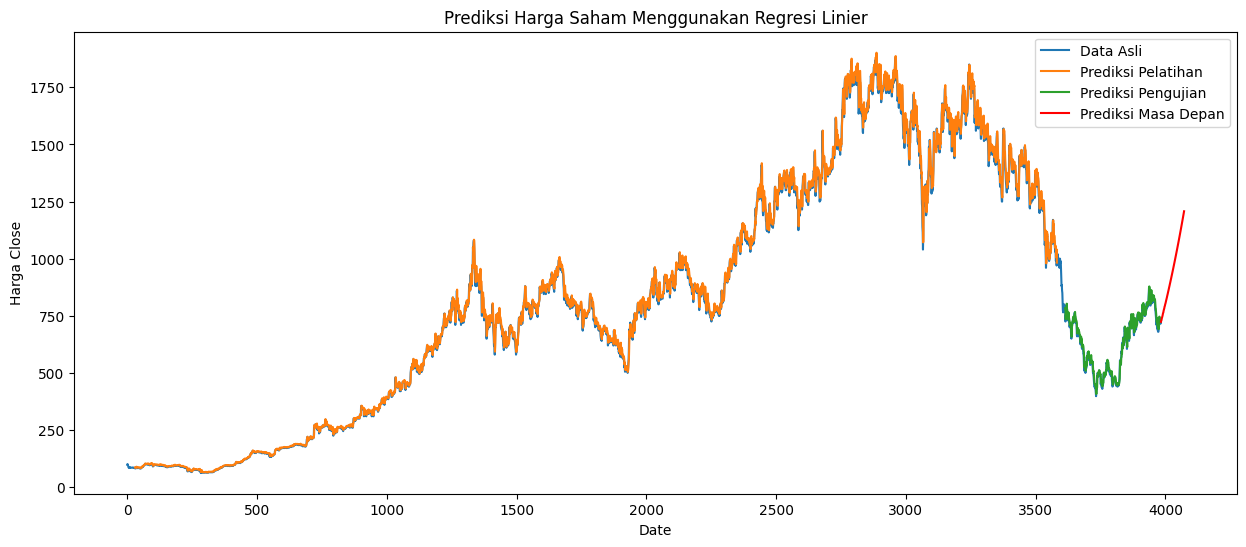

In [50]:
# Visualisasi data asli, prediksi dan nilai kedepan
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Data Asli')
plt.plot(train_plot, label='Prediksi Pelatihan')
plt.plot(test_plot, label='Prediksi Pengujian')
plt.plot(np.arange(len(df), len(df) + future_days), future_predictions, label='Prediksi Masa Depan', color='red')
plt.xlabel('Date')
plt.ylabel('Harga Close')
plt.title('Prediksi Harga Saham Menggunakan Regresi Linier')
plt.legend()
plt.show()


In [51]:

result_df.to_csv('linear_regression_prediction_90days.csv', index=False)
print('Hasil prediksi telah disimpan ke dalam file "linear_regression_prediction_90days.csv".')

Hasil prediksi telah disimpan ke dalam file "linear_regression_prediction_90days.csv".
